In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertModel, DistilBertTokenizer
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.metrics import confusion_matrix
import seaborn as sns

c:\Users\rober\anaconda3\envs\pytorch2024\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Extract text from file names as well as labels
def read_text_files_with_labels(path):
    texts = []
    labels = []
    class_folders = sorted(os.listdir(path))  # Assuming class folders are sorted
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}

    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            file_names = os.listdir(class_path)
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):
                    file_name_no_ext, _ = os.path.splitext(file_name)
                    text = file_name_no_ext.replace('_', ' ')
                    text_without_digits = re.sub(r'\d+', '', text)
                    texts.append(text_without_digits)
                    labels.append(label_map[class_name])

    return np.array(texts), np.array(labels)

# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Define the model
class DistilBERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DistilBERTClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(self.distilbert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)[0]
        output = self.drop(pooled_output[:,0])
        return self.out(output)

# Define training function
def train(model, iterator, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in iterator:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        output = model(input_ids, attention_mask)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(iterator)

# Define evaluation function
def evaluate(model, iterator, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in iterator:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            output = model(input_ids, attention_mask)
            loss = criterion(output, labels)

            total_loss += loss.item()

    return total_loss / len(iterator)

def predict(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():  # Disable gradient tracking
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)  # Assuming input_ids are in the batch
            attention_mask = batch['attention_mask'].to(device)  # Assuming attention_mask is in the batch

            # Forward pass
            outputs = model(input_ids, attention_mask)

            # Get predictions
            _, preds = torch.max(outputs, dim=1)

            # Convert predictions to CPU and append to the list
            predictions.extend(preds.cpu().numpy())

    return predictions

In [3]:
TRAIN_PATH = r"C:\Users\rober\OneDrive - University of Calgary\Projects\Garbage-classification\CVPR_2024_dataset\CVPR_2024_dataset\Train"
VAL_PATH = r"C:\Users\rober\OneDrive - University of Calgary\Projects\Garbage-classification\CVPR_2024_dataset\CVPR_2024_dataset\Validation"
TEST_PATH = r"C:\Users\rober\OneDrive - University of Calgary\Projects\Garbage-classification\CVPR_2024_dataset\CVPR_2024_dataset\Test"

text_train,labels_train = read_text_files_with_labels(TRAIN_PATH)
text_val,labels_val = read_text_files_with_labels(VAL_PATH)
text_test,labels_test = read_text_files_with_labels(TEST_PATH)

print(text_train.shape)
print(labels_train.shape)
print(text_val.shape)
print(labels_val.shape)
print(text_test.shape)
print(labels_test.shape)

(8000,)
(8000,)
(2000,)
(2000,)
(2000,)
(2000,)


In [ ]:
# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize data
max_len = 24
dataset_train = CustomDataset(text_train, labels_train, tokenizer, max_len)
dataset_val = CustomDataset(text_val, labels_val, tokenizer, max_len)
dataset_test = CustomDataset(text_test, labels_test, tokenizer, max_len)

# Data loaders
train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=8, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=8, shuffle=False)

best_loss = 1e+10 # best loss tracker
EPOCHS = 4

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DistilBERTClassifier(num_classes=4).to(device)

# Training parameters
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}')
    val_loss = evaluate(model, val_loader, criterion, device)
    print(f'Epoch: {epoch+1}, Val Loss: {val_loss:.4f}')
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

c:\Users\rober\anaconda3\envs\pytorch2024\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch: 1, Train Loss: 0.4766
Epoch: 1, Val Loss: 0.3418
Epoch: 2, Train Loss: 0.2720
Epoch: 2, Val Loss: 0.3291
Epoch: 3, Train Loss: 0.2092
Epoch: 3, Val Loss: 0.3398
Epoch: 4, Train Loss: 0.1622
Epoch: 4, Val Loss: 0.3469


In [5]:
model.load_state_dict(torch.load('best_model.pth'))
# Evaluation
test_predictions = predict(model, test_loader, device)
print(f"Accuracy:  {(test_predictions == labels_test).sum()/labels_test.size:.4f}")

C:\Users\rober\AppData\Local\Temp\ipykernel_33328\1749596883.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Accuracy:  0.8970


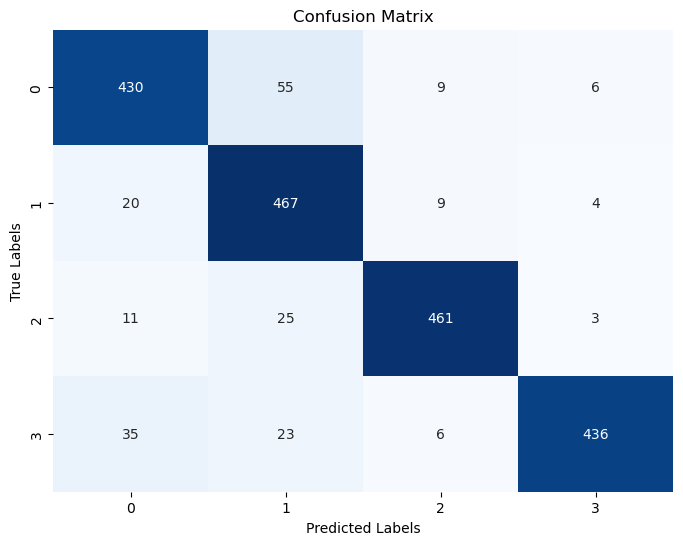

In [6]:
cm = confusion_matrix(labels_test, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
f_text -> D -> x -> N -> xnorm
f_image-> D -> x -> N -> xnorm